In [68]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy import stats
import statsmodels.api as sm


In [69]:
merged_data_path = os.path.join(os.getcwd(), 'data', 'merged_data')
master_train_path = os.path.join(merged_data_path, 'master_train.csv')
master_forecast_path = os.path.join(merged_data_path, 'master_forecast.csv')
df_master_train = pd.read_csv(master_train_path, low_memory=False)
df_master_train['date'] = pd.to_datetime(df_master_train['date'])
df_master_train = df_master_train.convert_dtypes()
df_master_forecast = pd.read_csv(master_forecast_path, low_memory=False)
df_master_forecast['date'] = pd.to_datetime(df_master_forecast['date'])
df_master_forecast = df_master_forecast.convert_dtypes()

In [70]:
# Missing data check - now that we have filled the null discountPct
missing_data = df_master_train.isnull().sum()
missing_pct = (missing_data / len(df_master_train)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_data,
    'Missing Percentage': missing_pct
})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)

print(missing_df)

# Save the null-handled training data back to the same file
df_master_train.to_csv(master_train_path, index=False)


                  Missing Count  Missing Percentage
promo_id                 297837           86.618545
discountPct              297837           86.618545
holidayEventName         271609           78.990778
FSC_index                    18            0.005235


In [71]:
df = df_master_train.copy()

# promo_id is not used in the model, the rest are subsumed by other variables
df = df.drop(
    columns=[
        "promo_id", "category", "holidayEventIndicator", "workingDayIndicator",
        "max_temp", "min_temp", "sunshine_hours", "precip_duration",
        "mean_wind_speed", "max_gust"
    ],
    errors="ignore"
)

df = df.dropna(subset=["FSC_index"])                 # drop obs if FSC_index is null
df["discountPct"] = df["discountPct"].fillna(0)      # set discountPct null to 0
df["holidayEventName"] = df["holidayEventName"].fillna("__NO_EVENT__")

cat_cols = ["mainProductGroup", "holidayEventName", "doWName"]

for c in cat_cols:
    print(f"\n{c} value counts:")
    print(df[c].value_counts())



mainProductGroup value counts:
mainProductGroup
Other               64470
Rood stevig         22793
Rood soepel         21659
Vis                 21565
Wasmiddelen         21560
Afwas               21450
Vleesconserven      21446
Lucht               21444
chocolade           21418
Wit vol             21342
Wit fris&fruitig    21313
suikerwerk          21294
Visconserven        21128
Vlees               20949
Name: count, dtype: Int64

holidayEventName value counts:
holidayEventName
__NO_EVENT__             271608
Sinterklaas_lag_5           973
Nieuwjaar_lead_1            963
Eerste Paasdag_lag_1        963
Goede Vrijdag               963
                          ...  
Bevrijdingsdag_lead_1       239
Moederdag_lag_4             239
Moederdag_lag_5             239
Hemelvaart_lag_5            238
Hemelvaart_lag_4            237
Name: count, Length: 89, dtype: Int64

doWName value counts:
doWName
Vrijdag      49313
Zaterdag     49295
Woensdag     49057
Dinsdag      49056
Donderdag    49

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 343831 entries, 0 to 343848
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date                343831 non-null  datetime64[ns]
 1   articleId           343831 non-null  string        
 2   storeCount          343831 non-null  Int64         
 3   FSC_index           343831 non-null  Float64       
 4   sales_volume_index  343831 non-null  Float64       
 5   discountPct         343831 non-null  Float64       
 6   mainProductGroup    343831 non-null  string        
 7   holidayEventName    343831 non-null  string        
 8   doWName             343831 non-null  string        
dtypes: Float64(3), Int64(1), datetime64[ns](1), string(4)
memory usage: 27.5 MB


In [73]:
# Define desired baselines
baseline_map = {
    "mainProductGroup": "Other",
    "holidayEventName": "__NO_EVENT__",
    "doWName": "Maandag"
}

for col, baseline in baseline_map.items():
    if col in df.columns:
        # Get all existing levels
        levels = df[col].astype("string").unique().tolist()
        # Put baseline first, keep others after
        ordered_levels = [baseline] + [x for x in levels if x != baseline]
        # Enforce category order
        df[col] = pd.Categorical(df[col], categories=ordered_levels, ordered=True)


In [74]:
df['sales_volume_index'] = np.log(df['sales_volume_index'])

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.623
Model:                            OLS   Adj. R-squared:                  0.596
Method:                 Least Squares   F-statistic:                     22.91
Date:                Thu, 15 Jan 2026   Prob (F-statistic):          2.96e-218
Time:                        17:04:07   Log-Likelihood:                -66.088
No. Observations:                1427   AIC:                             326.2
Df Residuals:                    1330   BIC:                             836.7
Df Model:                          96                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

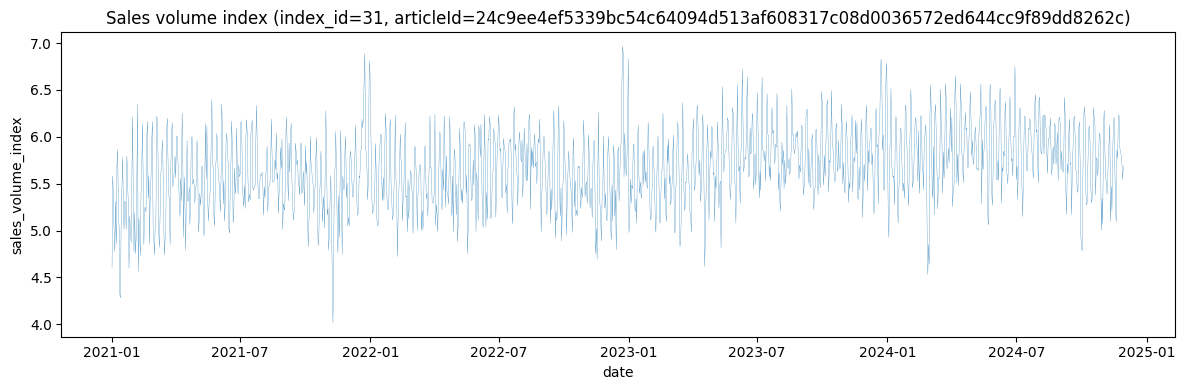

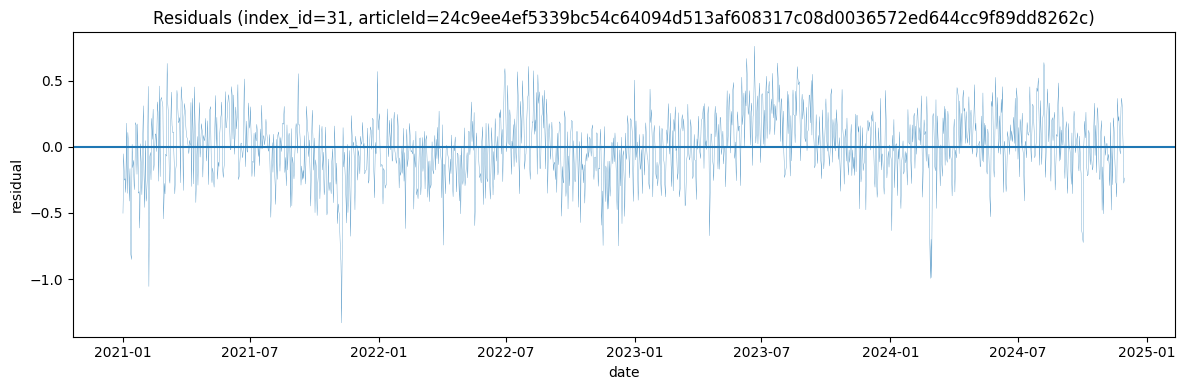

{'index_id': 31,
 'articleId': '24c9ee4ef5339bc54c64094d513af608317c08d0036572ed644cc9f89dd8262c',
 'mainProductGroup': ['Vis'],
 'n_rows': 1427,
 'date_min': Timestamp('2021-01-01 00:00:00'),
 'date_max': Timestamp('2024-11-30 00:00:00')}

In [75]:

# --- sequential index (1..N) -> articleId mapping ---
article_list = (
    df["articleId"]
    .dropna()
    .astype("string")
    .drop_duplicates()
    .sort_values()
    .to_list()
)
n_articles = len(article_list)

index_map = pd.DataFrame({
    "index_id": np.arange(1, n_articles + 1),
    "articleId": article_list
})

# --- run per-article OLS + plots + attributes ---
def run_article_ols(index_id: int):
    if not (1 <= index_id <= n_articles):
        raise ValueError(f"index_id must be in [1, {n_articles}]")

    aid = article_list[index_id - 1]
    d = df.loc[df["articleId"] == aid].sort_values("date")

    # attributes (returned)
    attrs = {
        "index_id": index_id,
        "articleId": aid,
        "mainProductGroup": d["mainProductGroup"].dropna().unique().tolist(),
        "n_rows": int(len(d)),
        "date_min": d["date"].min(),
        "date_max": d["date"].max(),
    }

    y = d["sales_volume_index"].astype(float)

    base_cols = ["storeCount", "FSC_index", "discountPct"]
    X = d[base_cols].astype(float)

    # categorical controls
    cat = pd.get_dummies(d[["holidayEventName", "doWName"]], drop_first=True)
    X = pd.concat([X, cat], axis=1)
    X = sm.add_constant(X, has_constant="add")

    # align + drop missing
    dm = pd.concat([d[["date"]], y.rename("y"), X], axis=1).dropna()
    dates = dm["date"]
    y_m = dm["y"]
    X_m = dm.drop(columns=["date", "y"])
    
    # Convert all columns to numeric (float) to avoid object dtype issues
    # This converts boolean columns from get_dummies to 0.0/1.0
    X_m = X_m.astype(float)

    model = sm.OLS(y_m, X_m).fit()

    # --- outputs ---
    print(model.summary())

    # original time series
    plt.figure(figsize=(12, 4))
    plt.plot(d["date"], d["sales_volume_index"].astype(float),linewidth=0.2)
    plt.title(f"Sales volume index (index_id={index_id}, articleId={aid})")
    plt.xlabel("date"); plt.ylabel("sales_volume_index")
    plt.tight_layout()
    plt.show()

    # residuals
    plt.figure(figsize=(12, 4))
    plt.plot(dates, model.resid, linewidth=0.2)
    plt.axhline(0)
    plt.title(f"Residuals (index_id={index_id}, articleId={aid})")
    plt.xlabel("date"); plt.ylabel("residual")
    plt.tight_layout()
    plt.show()

    return attrs

# Example:
attrs = run_article_ols(31)
attrs


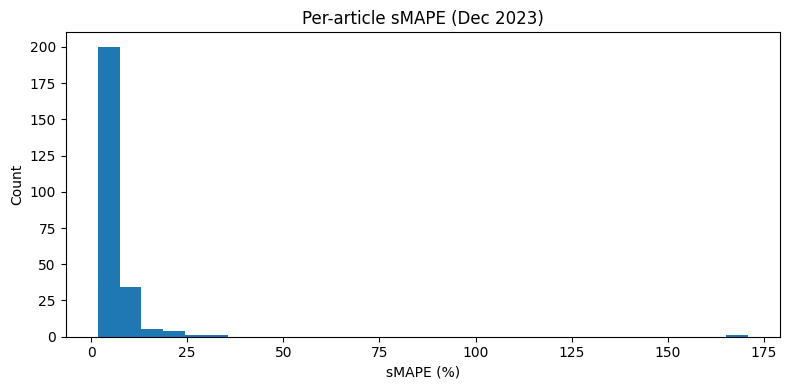

,index_id,articleId,n_train,n_test,smape
0,1,0112d194d01727f5f5ba3c835c9ef20b76a3432d74f771...,750,31,9.761192
1,2,030c9c75de06d0aee298db030bf76b1933bb5a9a28e3fb...,1064,31,4.613359
2,3,03a945e32405653c15915432f70ca7ec3b3709fe6abf28...,1064,31,6.157391
3,4,05f353ef4d503dd53818830120f4f479815b22d5ecc1c5...,1064,31,4.139948
4,5,06e708c215c11fe45c8b08104348be1cbdbd7ab7c1bf3e...,1064,31,4.927760


In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# --- sMAPE ---
def smape(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    # FIX: Added eps to denominator
    denom = np.abs(y_true) + np.abs(y_pred) + eps
    return np.mean(2.0 * np.abs(y_pred - y_true) / denom) * 100.0


# --- per-article train / test OLS + sMAPE ---
def run_article_ols_train_test(index_id: int):
    if not (1 <= index_id <= n_articles):
        raise ValueError(f"index_id must be in [1, {n_articles}]")

    aid = article_list[index_id - 1]
    d = df.loc[df["articleId"] == aid].sort_values("date").copy()

    # date split
    train_mask = (d["date"] >= "2021-01-01") & (d["date"] <= "2023-11-30")
    test_mask  = (d["date"] >= "2023-12-01") & (d["date"] <= "2023-12-31")

    d_train = d.loc[train_mask]
    d_test  = d.loc[test_mask]

    if len(d_train) == 0 or len(d_test) == 0:
        return {
            "index_id": index_id,
            "articleId": aid,
            "n_train": int(len(d_train)),
            "n_test": int(len(d_test)),
            "smape": np.nan
        }

    y_tr = d_train["sales_volume_index"].astype(float)
    y_te = d_test["sales_volume_index"].astype(float)

    base_cols = ["storeCount", "FSC_index", "discountPct"]

    X_tr = d_train[base_cols].astype(float)
    X_te = d_test[base_cols].astype(float)

    # categorical controls (fit dummies on train, align test)
    cat_tr = pd.get_dummies(d_train[["holidayEventName", "doWName"]], drop_first=True)
    cat_te = pd.get_dummies(d_test[["holidayEventName", "doWName"]], drop_first=True)
    cat_te = cat_te.reindex(columns=cat_tr.columns, fill_value=0)

    X_tr = pd.concat([X_tr, cat_tr], axis=1)
    X_te = pd.concat([X_te, cat_te], axis=1)

    X_tr = sm.add_constant(X_tr, has_constant="add")
    X_te = sm.add_constant(X_te, has_constant="add")

    # align + drop missing
    dm_tr = pd.concat([y_tr.rename("y"), X_tr], axis=1).dropna()
    dm_te = pd.concat([y_te.rename("y"), X_te], axis=1).dropna()

    if len(dm_tr) == 0 or len(dm_te) == 0:
         return {
            "index_id": index_id,
            "articleId": aid,
            "n_train": int(len(dm_tr)),
            "n_test": int(len(dm_te)),
            "smape": np.nan
        }

    y_tr_m = dm_tr["y"]
    X_tr_m = dm_tr.drop(columns=["y"]).astype(float)

    y_te_m = dm_te["y"]
    X_te_m = dm_te.drop(columns=["y"]).astype(float)

    # 1. Fit Model on Log Data
    model = sm.OLS(y_tr_m, X_tr_m).fit()
    
    # 2. Predict (Result is still in Log scale)
    y_hat_log = model.predict(X_te_m)
    
    # 3. CRITICAL FIX: Inverse Transform to Raw Scale
    # If you used np.log(), use np.exp()
    # If you used np.log1p(), use np.expm1()
    # I am assuming standard log here:
    y_hat_raw = np.exp(y_hat_log)
    y_te_raw = np.exp(y_te_m)

    # 4. Calculate sMAPE on Raw Scale
    return {
        "index_id": index_id,
        "articleId": aid,
        "n_train": int(len(y_tr_m)),
        "n_test": int(len(y_te_m)),
        "smape": smape(y_te_raw, y_hat_raw) # Pass raw values
    }


# --- run for all articles ---
results = []
for i in range(1, n_articles + 1):
    results.append(run_article_ols_train_test(i))

res_df = pd.DataFrame(results)

# --- per-article sMAPE distribution plot ---
valid = res_df["smape"].dropna()

plt.figure(figsize=(8, 4))
plt.hist(valid, bins=30)
plt.title("Per-article sMAPE (Dec 2023)")
plt.xlabel("sMAPE (%)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

res_df.head()


In [77]:
res_df["smape"].describe()

count    246.000000
mean       6.651589
std       11.292803
min        1.813441
25%        3.654122
50%        4.777344
75%        6.852716
max      170.760946
Name: smape, dtype: float64

In [78]:
res_df_ranked = res_df.sort_values(by="smape", ascending=False)

In [79]:
print(res_df_ranked["smape"])

230    170.760946
158     35.150554
6       28.766703
101     22.107188
32      22.044405
          ...    
27       2.292363
231      1.845528
198      1.813441
29            NaN
107           NaN
Name: smape, Length: 248, dtype: float64


In [80]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_article_rank_two_views_with_train_resid(rank_idx: int):
    row = res_df_ranked.iloc[rank_idx]
    aid = row["articleId"]

    d = df.loc[df["articleId"] == aid].sort_values("date").copy()

    train_mask = (d["date"] >= "2021-01-01") & (d["date"] <= "2023-11-30")
    test_mask  = (d["date"] >= "2023-12-01") & (d["date"] <= "2023-12-31")

    d_train = d.loc[train_mask].copy()
    d_test  = d.loc[test_mask].copy()

    if d_train.empty or d_test.empty:
        raise ValueError(f"No train/test data for articleId={aid} (train={len(d_train)}, test={len(d_test)})")

    # target
    y_tr = d_train["sales_volume_index"].astype(float)
    y_te = d_test["sales_volume_index"].astype(float)

    base_cols = ["storeCount", "FSC_index", "discountPct"]

    # features
    X_tr = d_train[base_cols].astype(float).copy()
    X_te = d_test[base_cols].astype(float).copy()
    
    # categorical controls (train dummies, align test)
    cat_tr = pd.get_dummies(d_train[["holidayEventName", "doWName"]], drop_first=True)
    cat_te = pd.get_dummies(d_test[["holidayEventName", "doWName"]], drop_first=True)
    cat_te = cat_te.reindex(columns=cat_tr.columns, fill_value=0)

    X_tr = pd.concat([X_tr, cat_tr], axis=1)
    X_te = pd.concat([X_te, cat_te], axis=1)

    X_tr = sm.add_constant(X_tr, has_constant="add")
    X_te = sm.add_constant(X_te, has_constant="add")

    # keep date; drop NaNs due to lags/dummies/etc.
    dm_tr = pd.concat([d_train[["date"]], y_tr.rename("y"), X_tr], axis=1).dropna()
    dm_te = pd.concat([d_test[["date"]],  y_te.rename("y"), X_te], axis=1).dropna()

    if dm_tr.empty or dm_te.empty:
        raise ValueError(f"After dropping NaNs: train={len(dm_tr)}, test={len(dm_te)} for articleId={aid}")

    tr_dates = dm_tr["date"]
    te_dates = dm_te["date"]

    y_tr_m = dm_tr["y"]
    X_tr_m = dm_tr.drop(columns=["date", "y"]).astype(float)

    y_te_m = dm_te["y"]
    X_te_m = dm_te.drop(columns=["date", "y"]).astype(float)

    model = sm.OLS(y_tr_m, X_tr_m).fit()

    # fitted on train + residuals (in-sample)
    y_fit_tr = model.predict(X_tr_m)
    resid_tr = y_tr_m - y_fit_tr

    # forecast on test + residuals (out-of-sample)
    y_hat_te = model.predict(X_te_m)
    resid_te = y_te_m - y_hat_te

    # for the top plot series line (actual full horizon)
    d_2123 = d.loc[(d["date"] >= "2021-01-01") & (d["date"] <= "2023-12-31")].copy()

    # ---------- Plot 1: 2021..Dec 2023 (top actual+forecast, bottom train+test residuals) ----------
    fig, (ax1, ax2) = plt.subplots(
        2, 1, figsize=(12, 7), sharex=True, gridspec_kw={"height_ratios": [2, 1]}
    )

    # top: actual series + Dec forecast
    ax1.plot(d_2123["date"], d_2123["sales_volume_index"].astype(float), linewidth=0.3, label="Actual")
    ax1.plot(te_dates, y_hat_te, linewidth=1.2, label="Forecast (Dec 2023)")
    ax1.axvline(pd.to_datetime("2023-12-01"), linestyle="--", linewidth=0.8)
    ax1.set_title(f"Article {aid} | rank_idx={rank_idx} | sMAPE={row['smape']:.2f}%")
    ax1.set_ylabel("sales_volume_index")
    ax1.legend()

    # bottom: residuals for train (fitted) + test (forecast)
    ax2.plot(tr_dates, resid_tr, linewidth=0.4, label="Train residual (fitted)")
    ax2.plot(te_dates, resid_te, linewidth=0.8, label="Test residual (forecast)")
    ax2.axhline(0, linewidth=0.8)
    ax2.set_ylabel("residual")
    ax2.set_xlabel("date")
    ax2.legend()

    plt.tight_layout()
    plt.show()

    # ---------- Plot 2: Zoom Dec 2023 (top actual+forecast, bottom forecast residuals) ----------
    fig, (bx1, bx2) = plt.subplots(
        2, 1, figsize=(12, 7), sharex=True, gridspec_kw={"height_ratios": [2, 1]}
    )

    bx1.plot(te_dates, y_te_m.values, linewidth=0.8, label="Actual (Dec 2023)")
    bx1.plot(te_dates, y_hat_te.values, linewidth=1.2, label="Forecast (Dec 2023)")
    bx1.set_title(f"Zoom: Dec 2023 | Article {aid}")
    bx1.set_ylabel("sales_volume_index")
    bx1.legend()

    bx2.plot(te_dates, resid_te.values, linewidth=0.8, label="Residual (forecast)")
    bx2.axhline(0, linewidth=0.8)
    bx2.set_ylabel("residual")
    bx2.set_xlabel("date")
    bx2.legend()

    # ---- format x-axis with readable dates ----
    locator = mdates.DayLocator(interval=2)          # tick every 2 days (change if needed)
    formatter = mdates.DateFormatter("%Y-%m-%d")

    bx2.xaxis.set_major_locator(locator)
    bx2.xaxis.set_major_formatter(formatter)
    fig.autofmt_xdate()  # rotate dates for readability

    plt.tight_layout()
    plt.show()



# Example:
# plot_article_rank_two_views_with_train_resid(0)

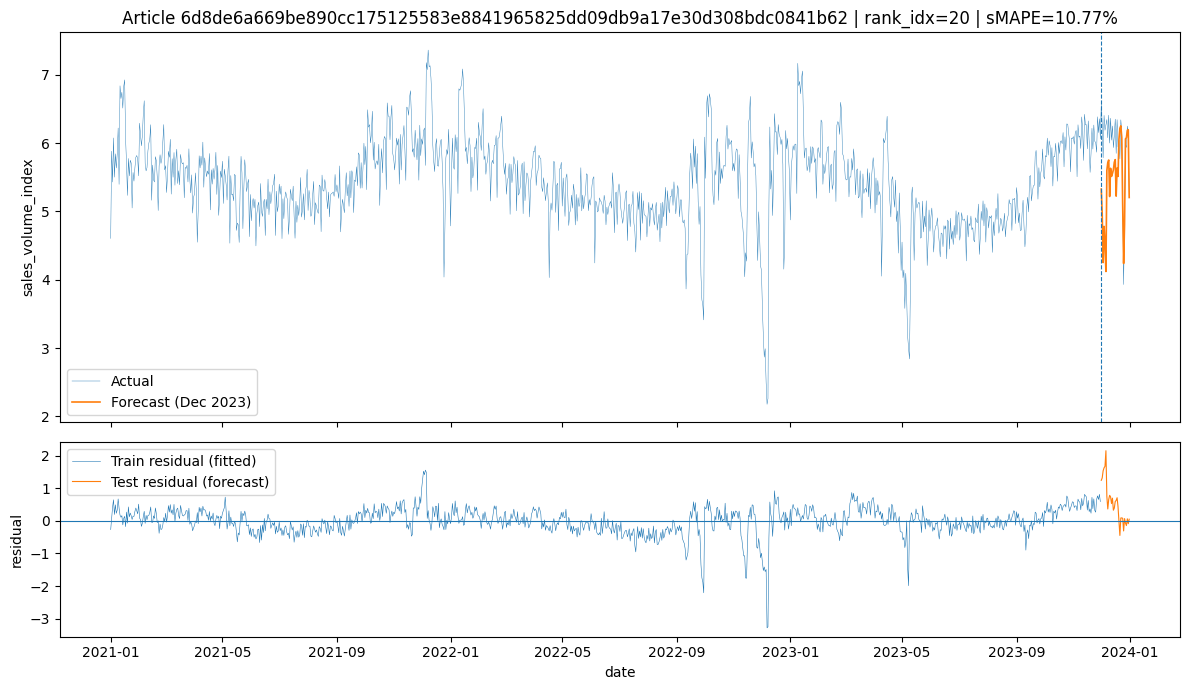

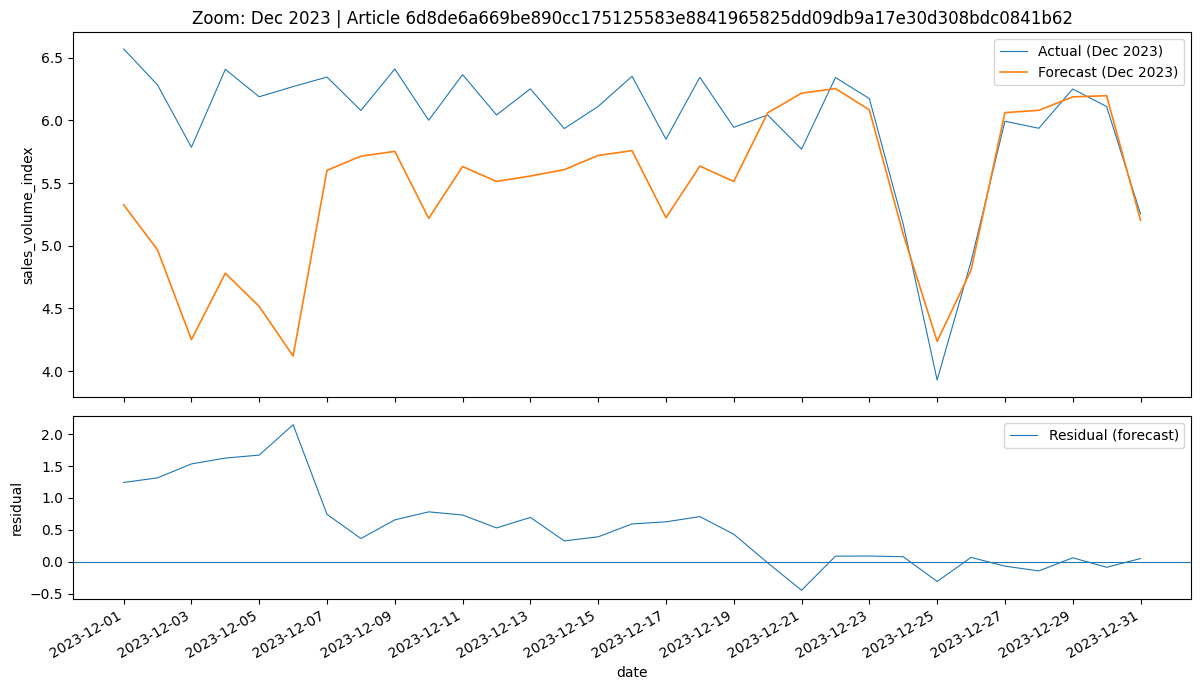

In [81]:
plot_article_rank_two_views_with_train_resid(20)